In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import read

%matplotlib inline

style_url = 'https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle'

In [2]:
years_historical = list(range(2015, 2020))

data_historical = read.query_data_range(years=years_historical, pollutants='SO2', expositions=24)
data_2020 = read.read_normalized_data(year=2020, pollutant='SO2', exposition=24)

In [3]:
data_historical.sort_values('timestamp')

timestamp  station_code  measurement pollutant  exposition  \
4748 2015-01-01  LbJarczWolaM          2.6       SO2          24   
4383 2015-01-01  DsSniezkaObs          1.4       SO2          24   
5113 2015-01-01  PmLebaRabkaE          0.8       SO2          24   
5478 2015-01-01  WmPuszczaBor          1.6       SO2          24   
5114 2015-01-02  PmLebaRabkaE          1.2       SO2          24   
...         ...           ...          ...       ...         ...   
4016 2019-12-30  LbJarczWolaM          2.6       SO2          24   
3651 2019-12-30  DsSniezkaObs          4.0       SO2          24   
4382 2019-12-31  PmLebaRabkaE          0.6       SO2          24   
4017 2019-12-31  LbJarczWolaM          1.6       SO2          24   
3652 2019-12-31  DsSniezkaObs          3.0       SO2          24   

                   region  
4748            LUBELSKIE  
4383         DOLNOSLASKIE  
5113            POMORSKIE  
5478  WARMINSKO-MAZURSKIE  
5114            POMORSKIE  
...                   ...  
4016            LUBELSKIE  
3651         DOLNOSLASKIE  
4382            POMORSKIE  
4017            LUBELSKIE  
3652         DOLNOSLASKIE  

[5843 rows x 6 columns]

In [4]:
daily_rolled_means_historical = data_historical.groupby('timestamp') \
    .agg({'measurement': np.nanmean}) \
    .rolling(14) \
    .mean()

daily_rolled_means_2020 = data_2020.groupby('timestamp') \
    .agg({'measurement': np.nanmean}) \
    .rolling(14) \
    .mean()

In [5]:
yearly_data = {year: daily_rolled_means_historical[daily_rolled_means_historical.index.year == year] for year in years_historical}

/tmp/ipykernel_145807/2445744159.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(sm, ticks=years_historical, label='Year')


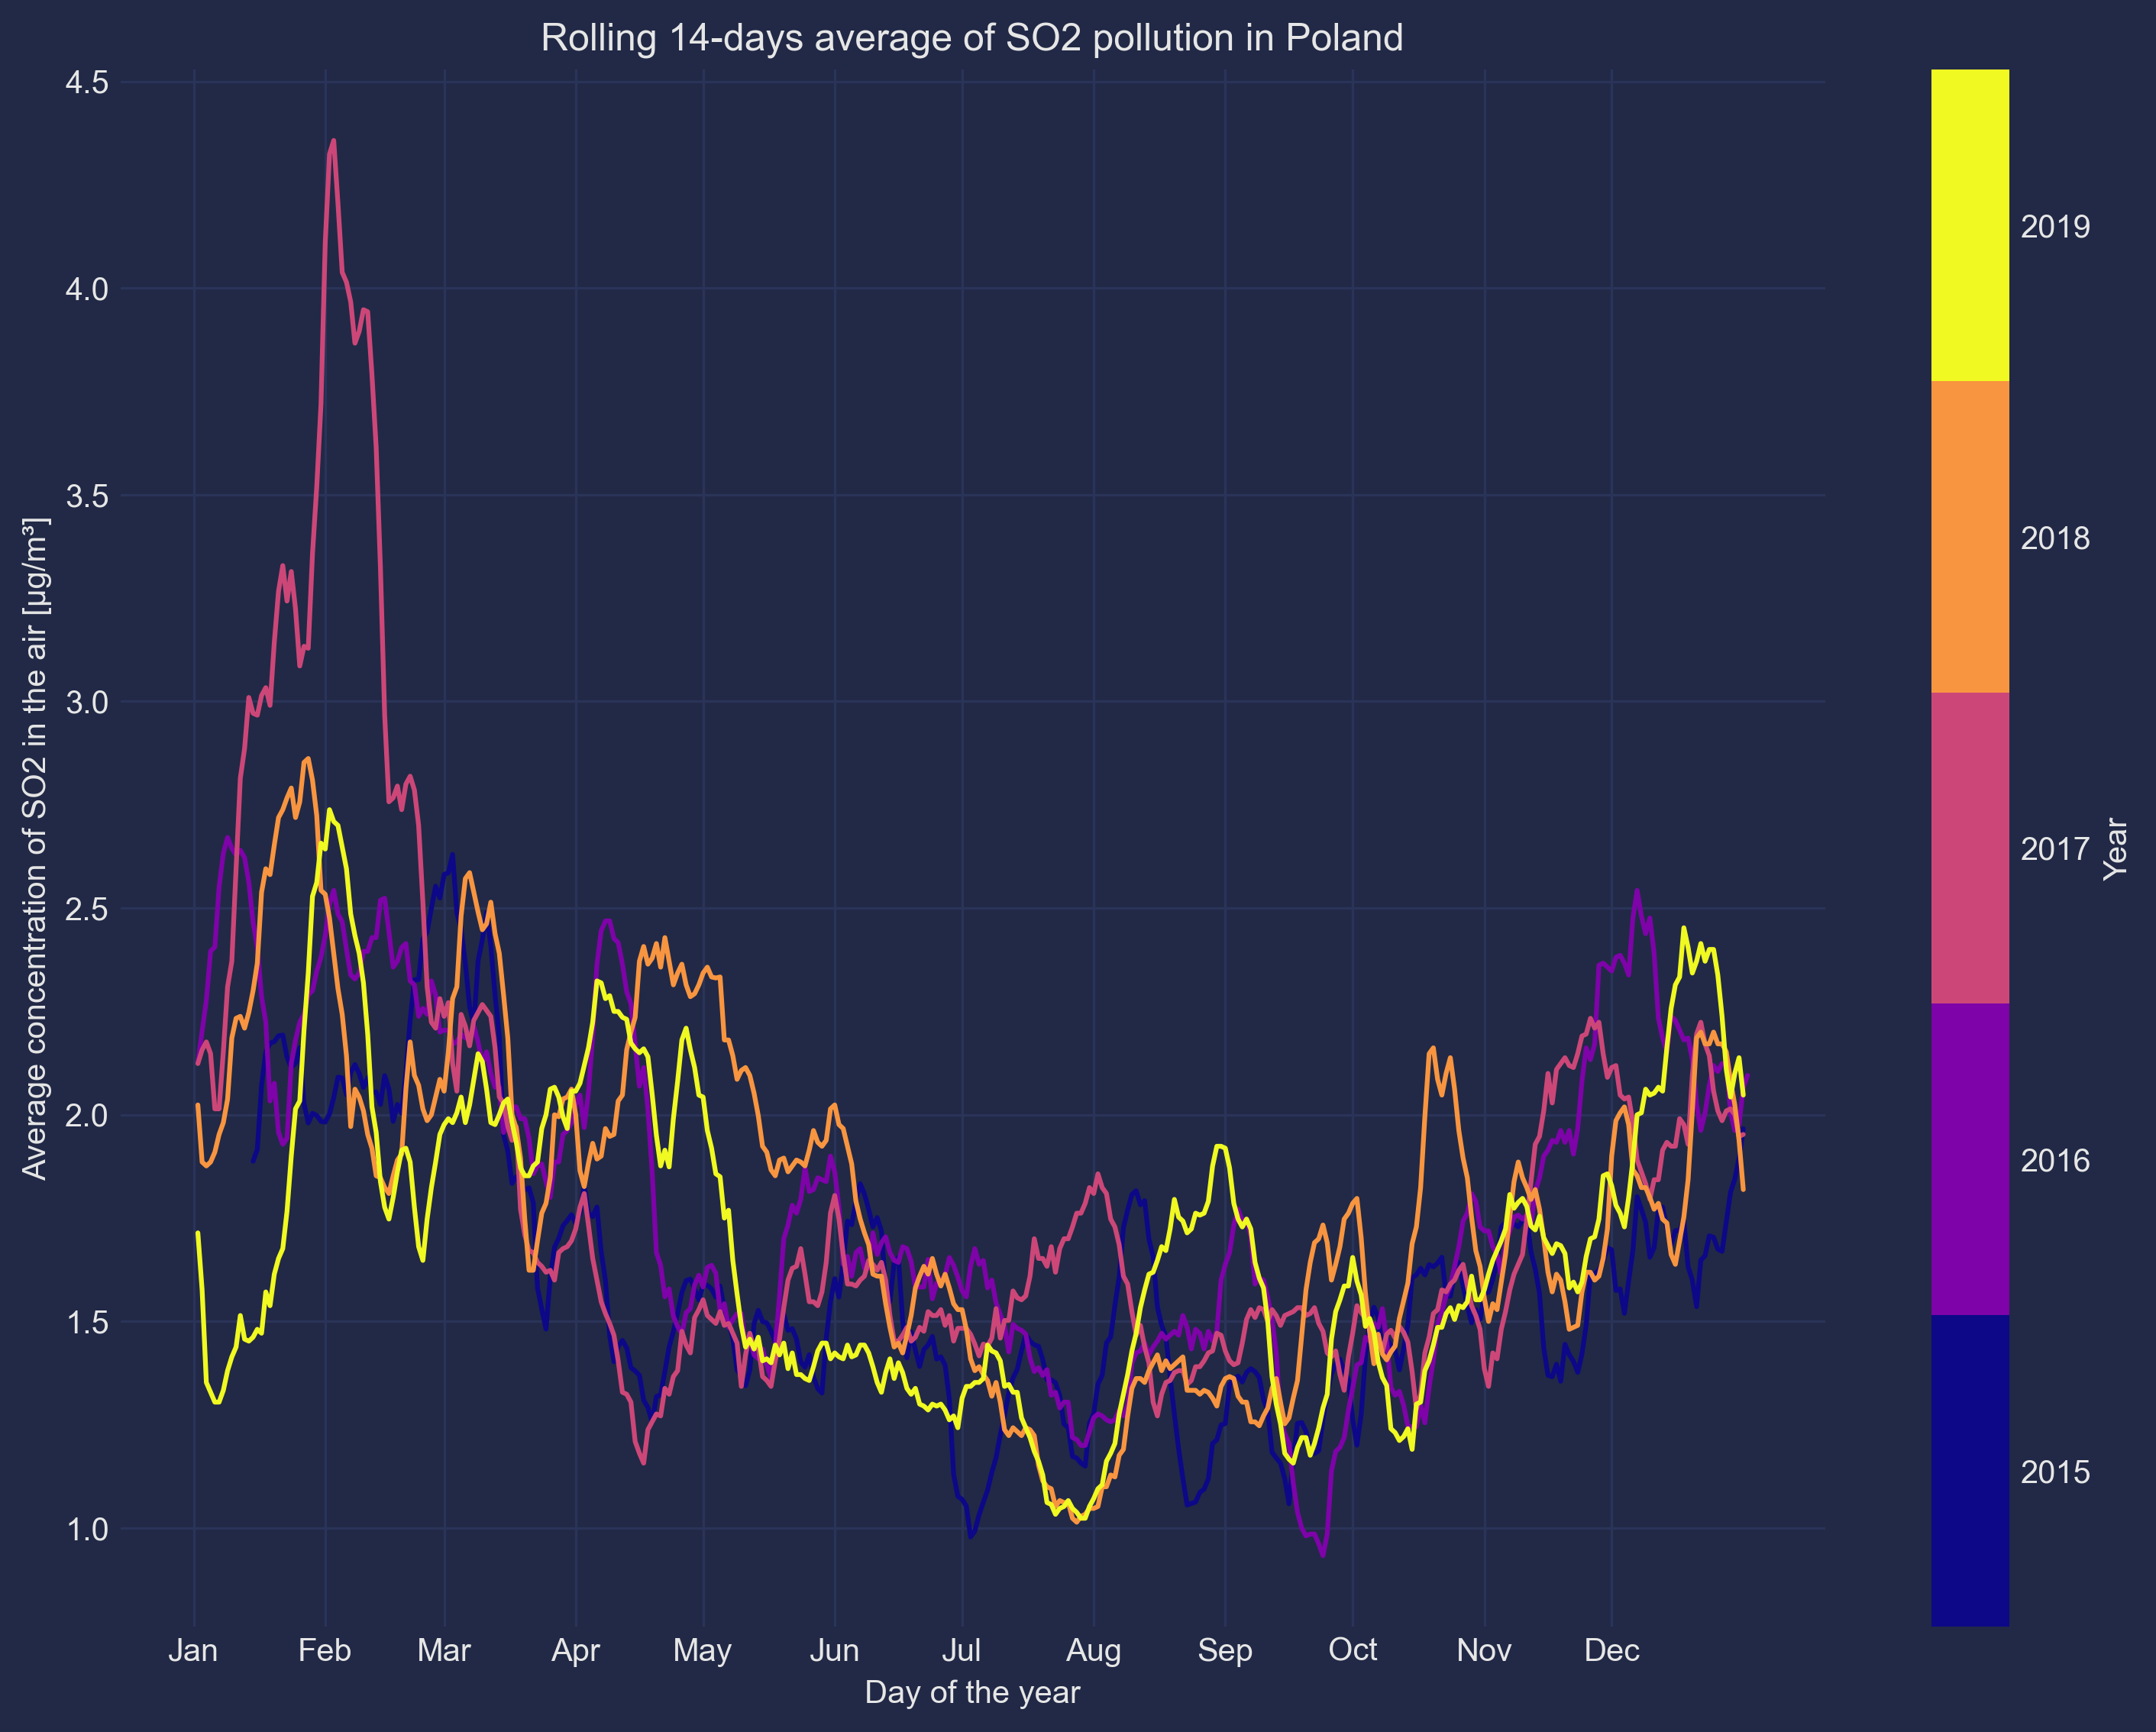

In [51]:
with plt.style.context(style_url):
    fig, ax = plt.subplots(figsize=(12, 9), dpi=300)

    colormap = plt.get_cmap('plasma', lut=len(years_historical))

    norm = mpl.colors.Normalize(vmin=min(years_historical), vmax=max(years_historical) + 1)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)

    for i, year in enumerate(years_historical):
        ax.plot(yearly_data[year].index.dayofyear, yearly_data[year].measurement, color=colormap(i))

    ax.set_title('Rolling 14-days average of SO2 pollution in Poland')
    ax.set_xlabel('Day of the year')
    ax.set_ylabel('Average concentration of SO2 in the air [μg/m³]')
    ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    colorbar = fig.colorbar(sm, ticks=years_historical, label='Year')
    colorbar.set_ticks([year + 0.5 for year in years_historical])
    colorbar.set_ticklabels(years_historical)
    
    plt.show()

In [7]:
over_years_average = daily_rolled_means_historical.groupby(daily_rolled_means_historical.index.dayofyear) \
    .agg({'measurement': [np.nanmean, np.nanstd]})

In [8]:
with plt.style.context(style_url):
    fig, ax = plt.subplots(figsize=(12, 9), dpi=300)

    ax.plot(over_years_average.index, over_years_average.measurement.nanmean, linestyle='dashed')
    ax.fill_between(over_years_average.index, 
                    over_years_average.measurement.nanmean - over_years_average.measurement.nanstd,
                   over_years_average.measurement.nanmean + over_years_average.measurement.nanstd,
                   color='gray', alpha=0.2)
    
    ax.plot(daily_rolled_means_2020.index.dayofyear, daily_rolled_means_2020.measurement)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    ax.axvline(85, color=colors[2])
    ax.text(86, 2.95, 'Mobility restrictions enacted', rotation=90, color=colors[2])
    
    ax.set_title('Comparison of SO2 pollution in Poland in years 2015-2019 to year 2020')
    ax.set_xlabel('Day of the year')
    ax.set_ylabel('Average concentration of SO2 in the air [μg/m³]')
    ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    
    legend_elements = [Line2D([0], [0], color=colors[0], 
                              linestyle='dashed', label='2015-2019 average'),
                   Patch(facecolor='gray', alpha=0.2,
                         label='Standard deviation from average'),
                   Line2D([0], [0], color=colors[1], label='2020')]
    
    ax.legend(handles=legend_elements)


In [12]:
df_mobility = pd.read_csv("data/mobility_trend_2022_04_10.csv")
df_mobility_Poland = df_mobility[df_mobility.region=="Poland"]
df_mobility_Poland = df_mobility_Poland.T
df_mobility_Poland = df_mobility_Poland.iloc[6:]-100 # set the 100 as the baseline, and convert data relative to it 
df_mobility_Poland = df_mobility_Poland.reset_index() # reset index
df_mobility_Poland.columns = ["Date","Driving","Walking"] # rename column

/tmp/ipykernel_145807/1968038242.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobility = pd.read_csv("data/mobility_trend_2022_04_10.csv")


In [13]:
df_mobility_Poland

Date Driving Walking
0    2020-01-13     0.0     0.0
1    2020-01-14    1.09   -1.02
2    2020-01-15    3.79    6.14
3    2020-01-16    8.02    8.21
4    2020-01-17   22.96   25.44
..          ...     ...     ...
814  2022-04-06   32.84   62.52
815  2022-04-07   38.29   78.19
816  2022-04-08   55.28   97.66
817  2022-04-09   40.87   99.42
818  2022-04-10   30.55   47.78

[819 rows x 3 columns]

In [30]:
dates = ['2020-01-13','2020-04-01','2020-07-01','2020-10-01',
         '2021-01-01','2021-04-01','2021-07-01','2021-10-01',
         '2022-01-01','2022-04-10']
indices = [None] * 10

for i, date in enumerate(dates):
    temp_df = df_mobility_Poland[df_mobility_Poland.Date==date]
    indices[i] = temp_df.index[0]

with plt.style.context(style_url):
    fig, ax = plt.subplots(figsize=(12, 9), dpi=300)
    ax.plot(df_mobility_Poland.Date, df_mobility_Poland.Driving)
    ax.plot(df_mobility_Poland.Date, df_mobility_Poland.Walking)
    
    ax.axvline(73, color=colors[2])
    ax.text(76, 90, 'Mobility restrictions enacted', rotation=90, color=colors[2])
    
    ax.set_title('Relative mobility of Apple devices users in Poland')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mobility relative to previous time periods')
    ax.set_xticks(indices)
    ax.set_xticklabels(['Jan 2020','Apr 2020','Jul 2020','Oct 2020','Jan 2021',
                    'Apr 2021','Jul 2021','Oct 2021','Jan 2022',
                    'Apr 2022'])
    ax.legend(['Driving', 'Walking'])
# firstcase["Walking"].plot(marker='o')

plt.show()

In [64]:
geo_data = gpd.read_file('data/Wojew¢dztwa.shp')
geo_data['region'] = ['SLASKIE', 'OPOLSKIE', 'SWIETOKRZYSKIE', 'POMORSKIE', 'PODLASKIE', 'ZACHODNIOPOMORSKIE', 
                      'DOLNOSLASKIE', 'WIELKOPOLSKIE', 'PODKARPACKIE', 'MALOPOLSKIE', 'WARMINSKO-MAZURSKIE', 
                      'LODZKIE', 'MAZOWIECKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE']

avg_pollution = read.query_data_range(2020, 'PM25', 24) \
.groupby(['timestamp', 'region']) \
.agg(np.nanmean) \
.reset_index() \
.groupby('region') \
.mean()

geo_data = geo_data.join(avg_pollution, on='region')

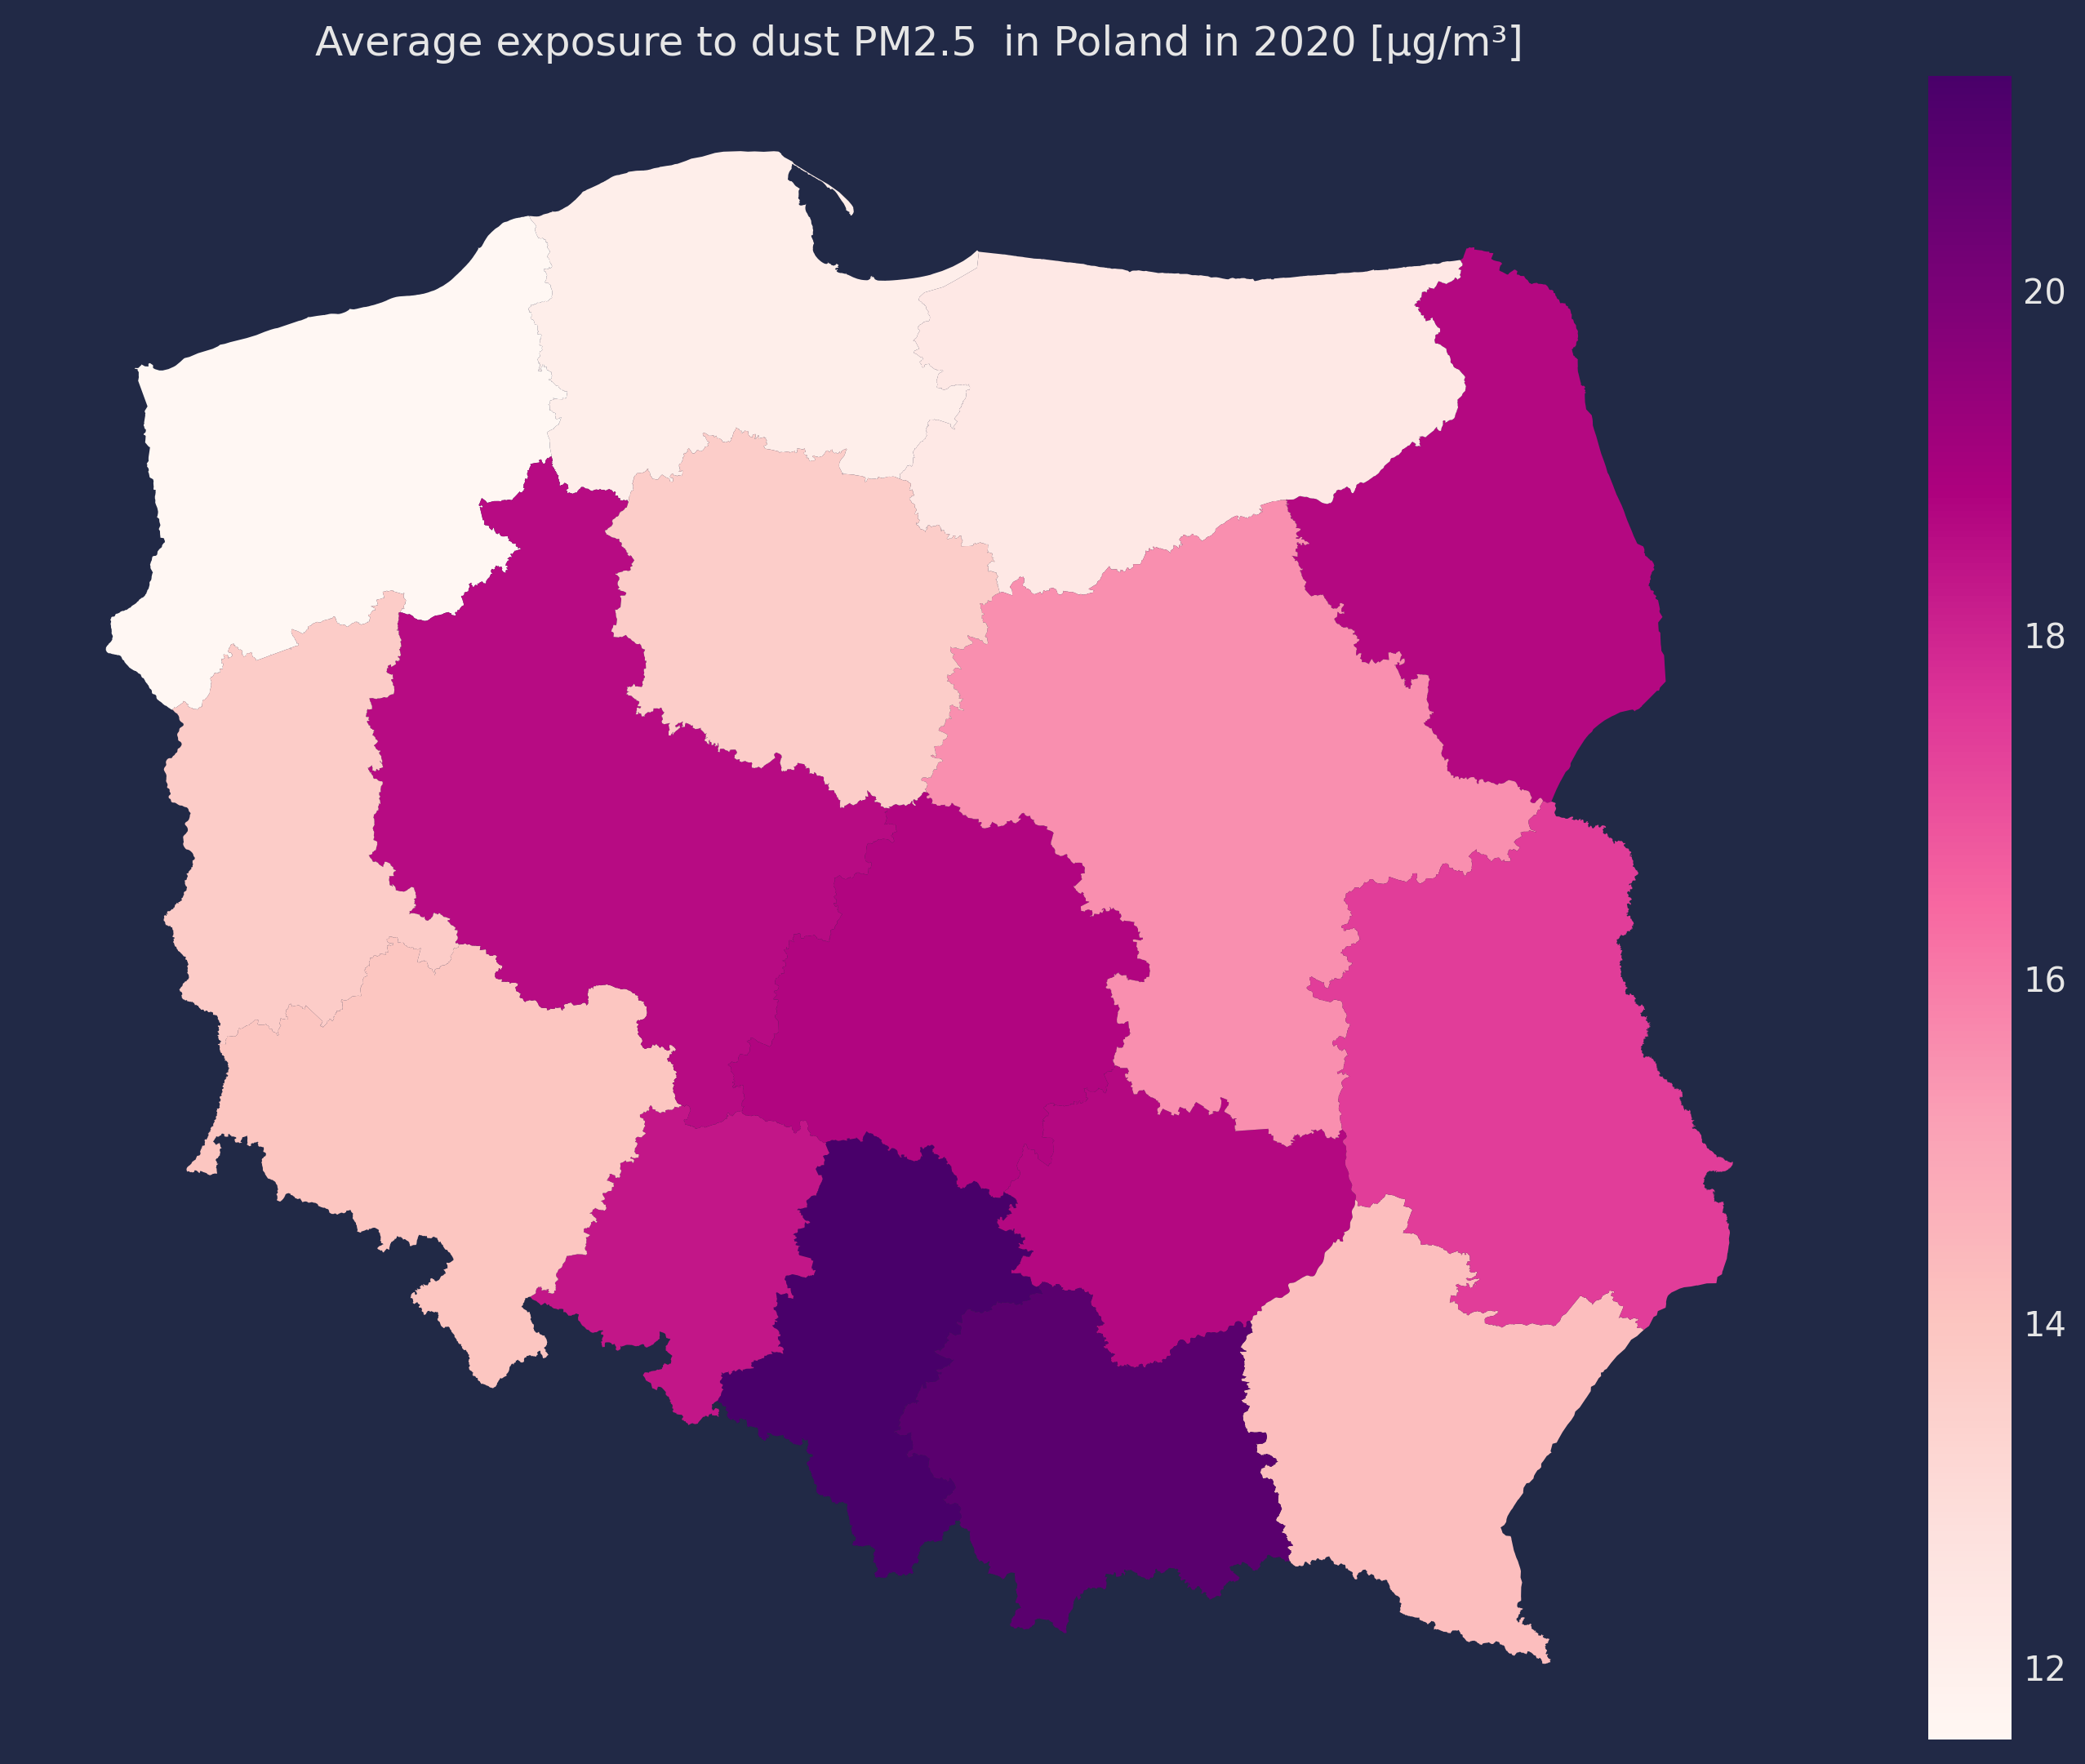

In [69]:
with plt.style.context(style_url):
    fig, ax = plt.subplots(figsize=(12, 9), dpi=300)

    geo_data.plot(column='measurement', legend=True, ax=ax)
    
    ax.set_title('Average exposure to dust PM2.5  in Poland in 2020 [μg/m³]')
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
data = read.query_data_range(years=list(range(2000, 2021)), pollutants=list(read.POLLUTANTS), expositions=[1, 24])

File "data/2000/2000_NOx_24g.xlsx" does not exists, skipping.
File "data/2000/2000_PM10_1g.xlsx" does not exists, skipping.
File "data/2000/2000_SO2_1g.xlsx" does not exists, skipping.
File "data/2000/2000_CO_24g.xlsx" does not exists, skipping.
File "data/2000/2000_CO_1g.xlsx" does not exists, skipping.
File "data/2000/2000_PM25_24g.xlsx" does not exists, skipping.
File "data/2000/2000_PM25_1g.xlsx" does not exists, skipping.
File "data/2000/2000_O3_24g.xlsx" does not exists, skipping.
File "data/2001/2001_NOx_24g.xlsx" does not exists, skipping.
File "data/2001/2001_PM10_1g.xlsx" does not exists, skipping.
File "data/2001/2001_CO_24g.xlsx" does not exists, skipping.
File "data/2001/2001_CO_1g.xlsx" does not exists, skipping.
File "data/2001/2001_PM25_24g.xlsx" does not exists, skipping.
File "data/2001/2001_PM25_1g.xlsx" does not exists, skipping.
File "data/2001/2001_O3_24g.xlsx" does not exists, skipping.
File "data/2002/2002_NOx_24g.xlsx" does not exists, skipping.
File "data/2002

/home/rafaczd/Studia/sem10/SNaDV/project/venv/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


File "data/2014/2014_NOx_24g.xlsx" does not exists, skipping.


/home/rafaczd/Studia/sem10/SNaDV/project/venv/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/home/rafaczd/Studia/sem10/SNaDV/project/venv/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/home/rafaczd/Studia/sem10/SNaDV/project/venv/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


File "data/2014/2014_CO_24g.xlsx" does not exists, skipping.


/home/rafaczd/Studia/sem10/SNaDV/project/venv/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


File "data/2014/2014_PM25_24g.xlsx" does not exists, skipping.
File "data/2014/2014_PM25_1g.xlsx" does not exists, skipping.
File "data/2014/2014_O3_24g.xlsx" does not exists, skipping.


/home/rafaczd/Studia/sem10/SNaDV/project/venv/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


File "data/2015/2015_NOx_24g.xlsx" does not exists, skipping.
File "data/2015/2015_CO_24g.xlsx" does not exists, skipping.
File "data/2015/2015_O3_24g.xlsx" does not exists, skipping.
File "data/2016/2016_NOx_24g.xlsx" does not exists, skipping.
File "data/2016/2016_CO_24g.xlsx" does not exists, skipping.
File "data/2016/2016_PM25_24g.xlsx" does not exists, skipping.
File "data/2016/2016_PM25_1g.xlsx" does not exists, skipping.
File "data/2016/2016_O3_24g.xlsx" does not exists, skipping.
File "data/2017/2017_NOx_24g.xlsx" does not exists, skipping.
